## Урок 9. Кейс 2. Внедрение модели в продукцию

Домашнее задание<br>
Нужно реализовать rest api на базе flask (пример https://github.com/fimochka-sudo/gb_flask_hw_api)<br>

По шагам:<br>
1. выбрать себе датасет (который интересен или нравится больше всего), сделать pipeline (преобразования + модель), сохранить его на диск. Если не хочется пайплайн, то можно без него, но так вам же будет удобнее потом вызывать его из кода сервиса.<br>
2. установить удобную для себя среду разработки (pycharm прекрасен - https://www.jetbrains.com/pycharm/)<br>
3. научиться создавать там виртуальное окружение для python (в правом нижнем углу есть add interpreter)<br>
4. для вашего проекта вам понадобится requirements.txt с пакетами. Можно за основу взять такой файл из проекта выше. Для его установки прям в pycharm можно открыть терминал и сделать pip install -r requirements.txt (находясь в корне проекта конечно же при этом)<br>
5. завести себе аккаунт на guthub (если его еще нет). У самого github есть такой "hello world" по работе с ним - https://guides.github.com/activities/hello-world/<br>
6. научиться запускать gunicorn (установить его конечно). Пример для проекта выше: gunicorn -w 5 -b 127.0.0.1:5000 run_server:app<br>
7. итоговый проект должен содержать: 1) каталог models/ (здесь модель-пайплайн предобученная) 2) файл run_server.py (здесь основной код flask-приложения) 3) requirements.txt (список пакетов, которые у вас используются в проекте) 4) README.md (здесь какое-то описание, что вы делаете, что за данные и т.д)<br>
8. (<b>Опционально</b>): front-end сервис какой-то, который умеет принимать от пользователя введеные данные и ходить в ваш api. На самом деле полезно больше вам, т.к если ваш проект будет далее развиваться (новые модели, интересные подходы), то это хороший пунктик к резюме и в принципе - строчка в портфолио)

### Обучим модель данных

In [138]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import lightgbm as lgbm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

In [139]:
def data_report(algorithm, testing_x, testing_y):
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print ("\n Classification report : \n", classification_report(testing_y, predictions))
    print ("Accuracy   Score : ", accuracy_score(testing_y, predictions))
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print ("Area under curve : ", model_roc_auc,"\n")
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [140]:
# https://www.kaggle.com/kemical/kickstarter-projects
data = pd.read_csv("ks-projects-201801.csv") 
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [141]:
# Оставляем только те данные, на которых можно учиться и предсказывать

In [142]:
data.drop(columns=['ID', 'currency', 'goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'], inplace=True)
data.head()

,name,category,main_category,deadline,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


In [143]:
target_name = 'state'
feature_names = data.columns.drop(target_name).tolist()

In [144]:
len(data)

378661

In [145]:
data = data[(data['state']=='failed') | (data['state']=='successful')]

In [146]:
data['state'] = data['state'].replace({'failed': 0, 'successful': 1})

In [147]:
data.dropna(inplace=True)

In [148]:
len(data)

331672

In [149]:
# Делим на трейн и тест

In [150]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=1)

train_X = train_data[feature_names] 
train_Y = train_data[target_name]
test_X = test_data[feature_names] 
test_Y = test_data[target_name]

In [151]:
#save test
#test_X.to_csv("X_test.csv", index=None)
#test_Y.to_csv("y_test.csv", index=None)
#save train
#train_X.to_csv("X_train.csv", index=None)
#train_Y.to_csv("y_train.csv", index=None)

#### EDA

In [152]:
print ("Rows:", train_data.shape[0])
print ("Columns:", train_data.shape[1])
print ("\nFeatures:\n", train_data.columns.tolist())
print ("\nMissing values:", train_data.isnull().sum().values.sum())
print ("\nUnique values:\n", train_data.nunique())

Rows: 232170
Columns: 8

Features:
 ['name', 'category', 'main_category', 'deadline', 'launched', 'state', 'country', 'usd_goal_real']

Missing values: 0

Unique values:
 name             231072
category            159
main_category        15
deadline           3078
launched         231980
state                 2
country              23
usd_goal_real     35026
dtype: int64


In [153]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232170 entries, 108275 to 146133
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           232170 non-null  object 
 1   category       232170 non-null  object 
 2   main_category  232170 non-null  object 
 3   deadline       232170 non-null  object 
 4   launched       232170 non-null  object 
 5   state          232170 non-null  int64  
 6   country        232170 non-null  object 
 7   usd_goal_real  232170 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 15.9+ MB


In [154]:
train_data.describe()

,state,usd_goal_real
count,232170.000000,2.321700e+05
mean,0.403808,4.058035e+04
std,0.490661,1.074746e+06
min,0.000000,1.500000e-01
25%,0.000000,2.000000e+03
50%,0.000000,5.000000e+03
75%,1.000000,1.500000e+04
max,1.000000,1.663614e+08


In [155]:
for cat_colname in train_data.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

name

New EP/Music Development                                 9
Reflections                                              8
Debut Album                                              8
Music Video                                              8
Romeo & Juliet                                           6
                                                        ..
My Name is Ryan Maelhorn and I Need to Finish my Film    1
Streetz Feature Film                                     1
New equipment for Joy's World!                           1
VLUL                                                     1
Benson Bye                                               1
Name: name, Length: 231072, dtype: int64
****************************************************************************************************

category

Product Design     13099
Documentary        10176
Music               8857
Tabletop Games      8181
Shorts              8046
                   ...  
Residencies           45
Letterpress      

In [156]:
print(len(train_data) - train_data.count())

name             0
category         0
main_category    0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64


In [157]:
train_data['state'].value_counts()

0    138418
1     93752
Name: state, dtype: int64

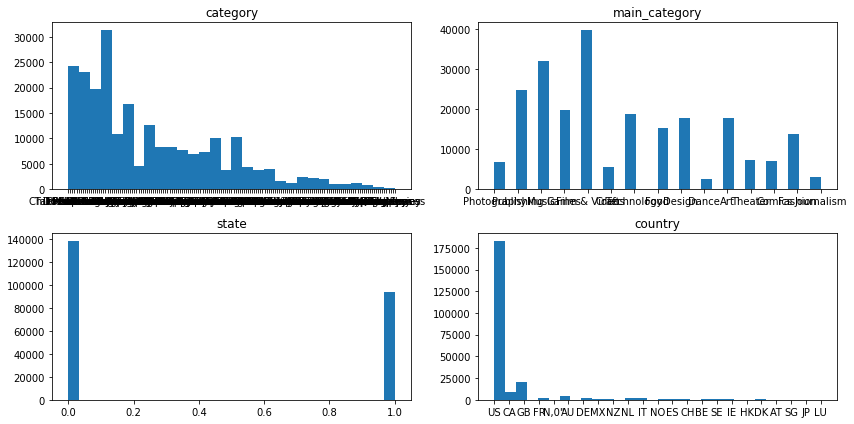

In [158]:
fig, axs = plt.subplots(2, 2, figsize = (12, 6))
ax = axs.flatten()
for i, c in enumerate(['category', 'main_category', 'state', 'country']):
    ax[i].hist(train_data[c], bins=30, label="Data")
    ax[i].set_title(c)
fig.tight_layout()

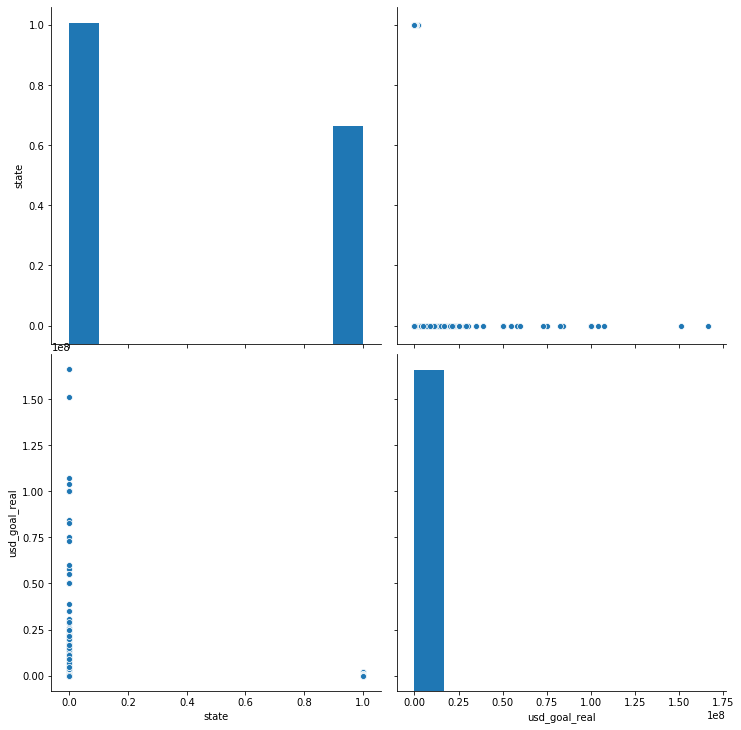

In [159]:
sns.pairplot(train_data, height=5)

In [160]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.loc[:, self.key]

class DateEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dd = pd.to_datetime(X)
        return pd.DataFrame(np.hstack((pd.DataFrame(dd.dt.month), pd.DataFrame(dd.dt.day))))
    
    def get_feature_names(self):
        return ['base_' + self.key + '_month', 'base_' + self.key + '_day']

class CalcPeriod(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame((pd.to_datetime(X.iloc[:,1]) - pd.to_datetime(X.iloc[:,0])).dt.days)
    
    def get_feature_names(self):
        return ['base_' + self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X[self.key])
    
    def get_feature_names(self):
        return ['base_' + self.key]
    
class ColumnCatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key, drop_first=True).columns]
        return self
    
    def transform(self, X):
        dummies = pd.get_dummies(X, prefix=self.key)
        dummies_columns = [col for col in dummies.columns]
        for col_ in self.columns:
            if col_ not in dummies_columns:
                dummies[col_] = 0
        return dummies[self.columns]
    
    def get_feature_names(self):
        return self.columns

In [161]:
name = Pipeline([
    ('selector', ColumnSelector(key='name')),
    ('result', TfidfVectorizer(max_df=0.90, min_df=10, strip_accents='ascii', max_features=5000)),
])
category = Pipeline([
    ('selector', ColumnSelector(key='category')),
    ('result', ColumnCatEncoder(key='category')),
])
main_category = Pipeline([
    ('selector', ColumnSelector(key='main_category')),
    ('result', ColumnCatEncoder(key='main_category')),
])
period = Pipeline([
    ('selector', ColumnSelector(key=['launched', 'deadline'])),
    ('result', CalcPeriod(key='period')),
])
country = Pipeline([
    ('selector', ColumnSelector(key='country')),
    ('result', ColumnCatEncoder(key='country')),
])
usd_goal_real = Pipeline([
    ('result', NumberSelector(key='usd_goal_real')),
])
launched = Pipeline([
    ('selector', ColumnSelector(key='launched')),
    ('result', DateEncoder(key='launched')),
])
deadline = Pipeline([
    ('selector', ColumnSelector(key='deadline')),
    ('result', DateEncoder(key='deadline')),
])

feats = FeatureUnion(transformer_list=[
    ('name', name),
    ('category', category),
    ('main_category', main_category),
    ('period', period),
    ('country', country),
    ('usd_goal_real', usd_goal_real),
    ('launched', launched),
    ('deadline', deadline),
])

In [162]:
ft = feats.fit_transform(train_X)

# Новый список фичей
new_features = []
for i in feats.transformer_list:
    new_features = np.hstack((new_features, i[1].named_steps['result'].get_feature_names()))

new_train_X = pd.DataFrame.sparse.from_spmatrix(ft, columns=new_features)
#new_train_X = pd.DataFrame(ft, columns=new_features)
new_train_X

,000,01,10,100,1000,101,10th,11,12,13,...,country_NO,country_NZ,country_SE,country_SG,country_US,base_usd_goal_real,base_launched_month,base_launched_day,base_deadline_month,base_deadline_day
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2950.00,11.0,21.0,12.0,21.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,12000.00,2.0,23.0,3.0,25.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,18000.00,2.0,14.0,4.0,14.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,6200.00,8.0,15.0,9.0,17.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8930.96,9.0,4.0,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,7000.00,5.0,10.0,6.0,12.0
232166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1000.00,5.0,24.0,7.0,23.0
232167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,75000.00,6.0,7.0,8.0,6.0
232168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,9000.00,7.0,27.0,8.0,26.0


In [163]:
# Формируем список категориальных признаков
cat_features = new_features.tolist()
for i in ['base_period', 'base_usd_goal_real', 'base_launched_month', 'base_launched_day', 
          'base_deadline_month', 'base_deadline_day']:
    cat_features.remove(i)

#### Обучение модели

In [164]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', lgbm.LGBMClassifier(random_state=1, class_weight='balanced')), #, class_weight={0: 1, 1: 1.5})),
])

In [165]:
%%time

#hyperparameters = { 'classifier__max_depth': [3, 5, 7],
#                    'classifier__n_estimators': [50, 100, 200],
#                    'classifier__num_leaves': [5, 20, 50]
#                  }
#hyperparameters = { 'classifier__max_depth': [11, 15, 20],
#                    'classifier__n_estimators': [400, 500, 600],
#                    'classifier__num_leaves': [10, 20, 30, 50]
#                  }
hyperparameters = { 'classifier__max_depth': [20],
                    'classifier__n_estimators': [500],
                    'classifier__num_leaves': [30]
                  }
gs = GridSearchCV(pipeline, hyperparameters, scoring='f1', cv=3, n_jobs=-1)
gs.fit(train_X, train_Y)

CPU times: user 3min 36s, sys: 2.19 s, total: 3min 38s
Wall time: 1min 4s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('name',
                                                                        Pipeline(steps=[('selector',
                                                                                         ColumnSelector(key='name')),
                                                                                        ('result',
                                                                                         TfidfVectorizer(max_df=0.9,
                                                                                                         max_features=5000,
                                                                                                         min_df=10,
                                                                                                         strip_accents='ascii'))])),
                                         

In [166]:
gs.best_params_

{'classifier__max_depth': 20,
 'classifier__n_estimators': 500,
 'classifier__num_leaves': 30}


 Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.71      0.76    138418
           1       0.64      0.74      0.69     93752

    accuracy                           0.73    232170
   macro avg       0.72      0.73      0.72    232170
weighted avg       0.74      0.73      0.73    232170

Accuracy   Score :  0.725106602920274
Area under curve :  0.7282401597408537 



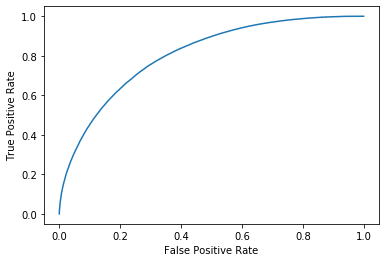

In [174]:
data_report(gs.best_estimator_, train_X, train_Y)


 Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.69      0.73     59298
           1       0.60      0.70      0.65     40204

    accuracy                           0.69     99502
   macro avg       0.69      0.69      0.69     99502
weighted avg       0.70      0.69      0.70     99502

Accuracy   Score :  0.6934332978231593
Area under curve :  0.6949558721900144 



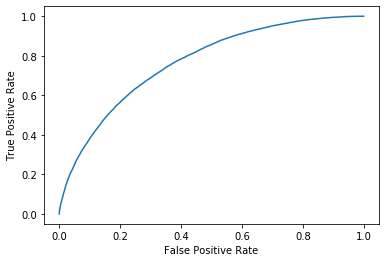

In [175]:
data_report(gs.best_estimator_, test_X, test_Y)

In [168]:
# Посмотрим на первые 20 важных признаков
ind = np.argsort(gs.best_estimator_.steps[1][1].feature_importances_)[:-20:-1]
for feat, importance in zip(new_features[ind], gs.best_estimator_.steps[1][1].feature_importances_[ind]):
    print(feat, '=', importance)

base_usd_goal_real = 1041
base_period = 587
base_deadline_day = 342
base_launched_day = 321
base_launched_month = 258
base_deadline_month = 231
the = 224
country_US = 81
category_Tabletop Games = 76
main_category_Film & Video = 71
for = 69
of = 66
and = 47
main_category_Music = 47
to = 44
in = 44
category_Apps = 44
main_category_Technology = 44
main_category_Food = 43


In [169]:
# Всё логично. Самые важные признаки - целевая сумма и срок.

In [170]:
%%time
# А теперь финальную модель обучим на всей выборке
pipeline = Pipeline([
    ('features', feats),
    ('classifier', lgbm.LGBMClassifier(random_state=1, class_weight='balanced', max_depth=20, n_estimators=500, num_leaves=30))
])
    
pipeline.fit(data.drop(columns=[target_name]), data[target_name])

CPU times: user 4min 18s, sys: 1.31 s, total: 4min 19s
Wall time: 18.8 s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('name',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='name')),
                                                                 ('result',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  max_features=5000,
                                                                                  min_df=10,
                                                                                  strip_accents='ascii'))])),
                                                ('category',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='category')),
                             


 Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.70      0.75    197716
           1       0.63      0.73      0.68    133956

    accuracy                           0.72    331672
   macro avg       0.71      0.72      0.71    331672
weighted avg       0.73      0.72      0.72    331672

Accuracy   Score :  0.7167321932511638
Area under curve :  0.7196131296004632 



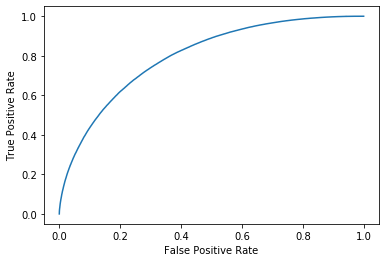

In [171]:
data_report(pipeline, data.drop(columns=[target_name]), data[target_name])

In [172]:
with open("pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

In [173]:
# Справочники для фронта
pd.DataFrame(sorted(data['main_category'].value_counts(dropna=True).index), 
             columns=['main_category']).to_csv("main_category.csv", index=None)
pd.DataFrame(sorted(data['category'].value_counts(dropna=True).index), 
             columns=['category']).to_csv("category.csv", index=None)
pd.DataFrame(sorted(data['country'].value_counts(dropna=True).index), 
             columns=['country']).to_csv("country.csv", index=None)